In [17]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [18]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full_corrected.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full_corrected.csv
Name of the anagraphic dataset: labels.csv


In [19]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    feat_to_predict = 'Sex_Category'
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    labels['Sex_Category'] = labels['Sex_Category'].map(lambda x: 0 if x.lower()=='male' else 1)

    return data, labels

In [20]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [21]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [22]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [23]:
def ml_analysis(feat_to_predict, audio=True):
    feat_to_predict = 'Sex_Category'
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(1000):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### Full Data

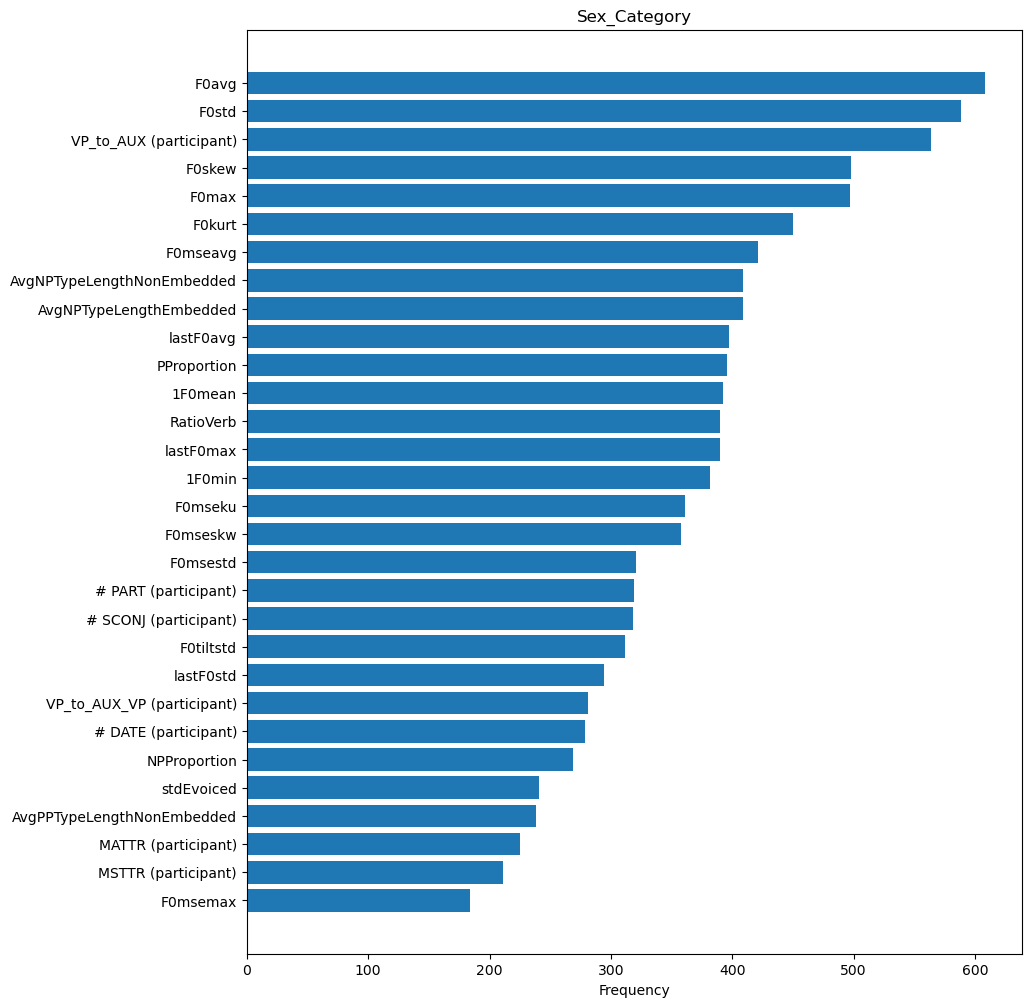

F0avg, F0std, VP_to_AUX (participant), F0skew, F0max,
F0kurt, F0mseavg, AvgNPTypeLengthNonEmbedded, AvgNPTypeLengthEmbedded, lastF0avg,
PProportion, 1F0mean, RatioVerb, lastF0max, 1F0min,
F0mseku, F0mseskw, F0msestd, # PART (participant), # SCONJ (participant),
F0tiltstd, lastF0std, VP_to_AUX_VP (participant), # DATE (participant), NPProportion,
stdEvoiced, AvgPPTypeLengthNonEmbedded, MATTR (participant), MSTTR (participant), F0msemax,


In [24]:
ML_FULL_COMPUTED_FEATURES = ml_analysis('Sex_Category')

### No Audio

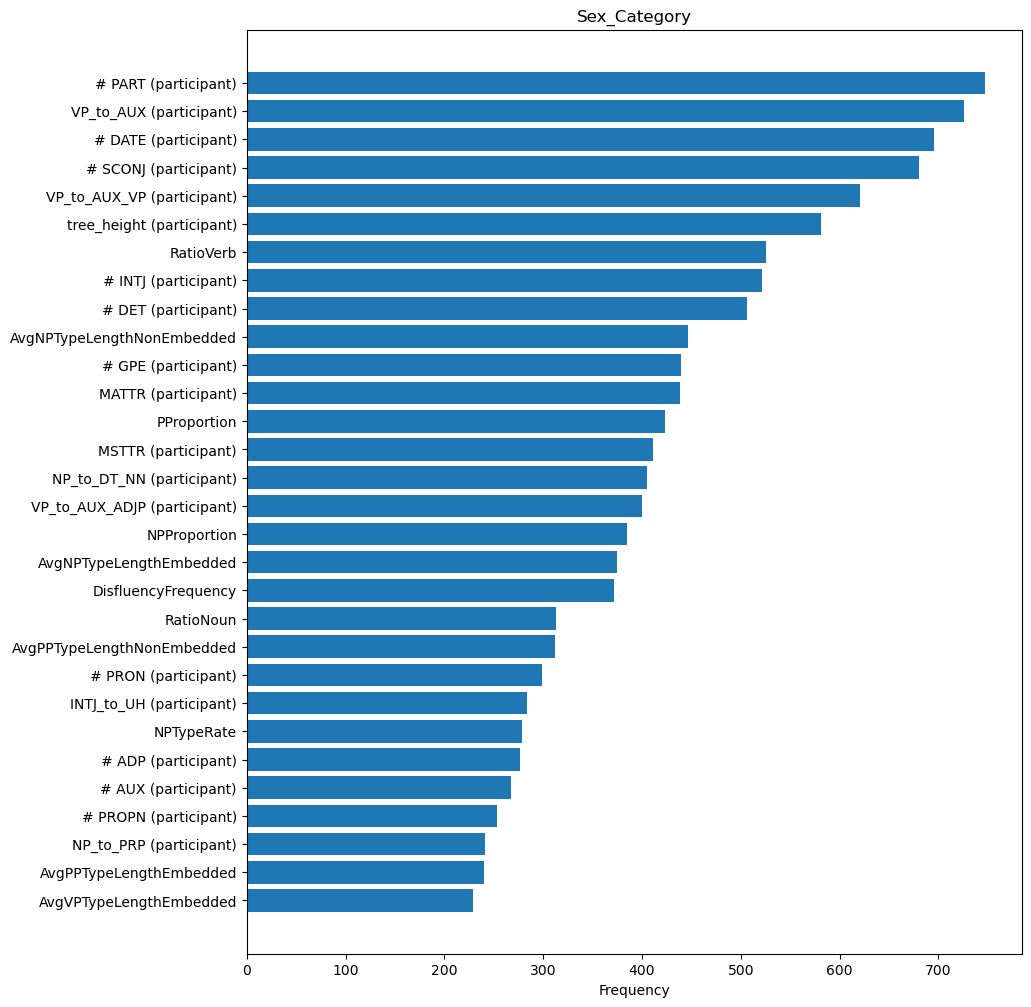

# PART (participant), VP_to_AUX (participant), # DATE (participant), # SCONJ (participant), VP_to_AUX_VP (participant),
tree_height (participant), RatioVerb, # INTJ (participant), # DET (participant), AvgNPTypeLengthNonEmbedded,
# GPE (participant), MATTR (participant), PProportion, MSTTR (participant), NP_to_DT_NN (participant),
VP_to_AUX_ADJP (participant), NPProportion, AvgNPTypeLengthEmbedded, DisfluencyFrequency, RatioNoun,
AvgPPTypeLengthNonEmbedded, # PRON (participant), INTJ_to_UH (participant), NPTypeRate, # ADP (participant),
# AUX (participant), # PROPN (participant), NP_to_PRP (participant), AvgPPTypeLengthEmbedded, AvgVPTypeLengthEmbedded,


In [25]:
ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('Sex_Category', audio=False)

# Statistical Approach

In [26]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [27]:
def f_info(feat_to_predict: str, audio=True):
    feat_to_predict = 'Sex_Category'
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

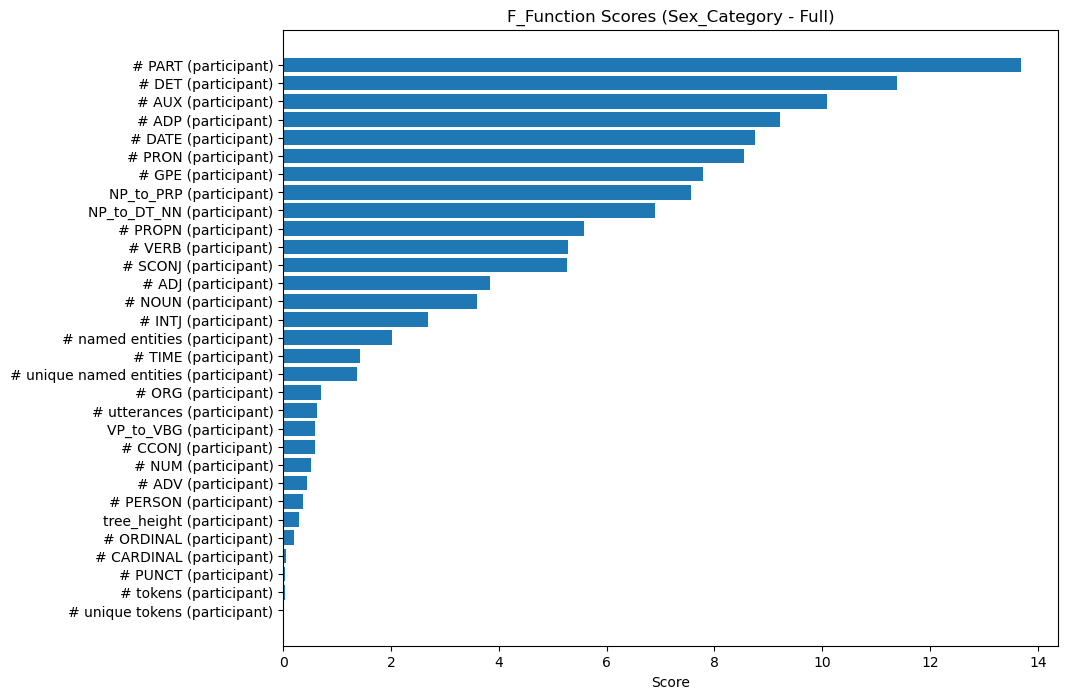

# PART (participant), # DET (participant), # AUX (participant), # ADP (participant), # DATE (participant),
# PRON (participant), # GPE (participant), NP_to_PRP (participant), NP_to_DT_NN (participant), # PROPN (participant),
# VERB (participant), # SCONJ (participant), # ADJ (participant), # NOUN (participant), # INTJ (participant),
# named entities (participant), # TIME (participant), # unique named entities (participant), # ORG (participant), # utterances (participant),
VP_to_VBG (participant), # CCONJ (participant), # NUM (participant), # ADV (participant), # PERSON (participant),
tree_height (participant), # ORDINAL (participant), # CARDINAL (participant), # PUNCT (participant), # tokens (participant),
# unique tokens (participant)


In [28]:
F_CLASSIF_FULL_COMPUTED_FEATURES = f_info('Sex_Category')

### No Audio

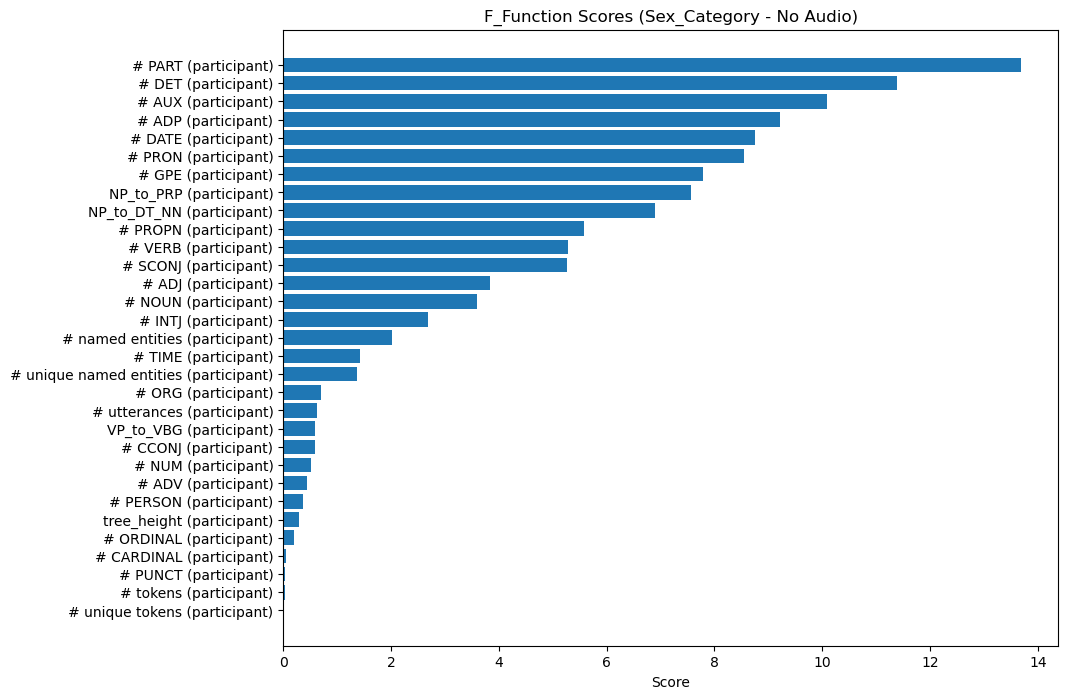

# PART (participant), # DET (participant), # AUX (participant), # ADP (participant), # DATE (participant),
# PRON (participant), # GPE (participant), NP_to_PRP (participant), NP_to_DT_NN (participant), # PROPN (participant),
# VERB (participant), # SCONJ (participant), # ADJ (participant), # NOUN (participant), # INTJ (participant),
# named entities (participant), # TIME (participant), # unique named entities (participant), # ORG (participant), # utterances (participant),
VP_to_VBG (participant), # CCONJ (participant), # NUM (participant), # ADV (participant), # PERSON (participant),
tree_height (participant), # ORDINAL (participant), # CARDINAL (participant), # PUNCT (participant), # tokens (participant),
# unique tokens (participant)


In [29]:
F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('Sex_Category', audio=False)

## Mutual Information

In [30]:
def m_info(to_predict, runs=1000, audio=True):
    to_predict = 'Sex_Category'
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### Full Data

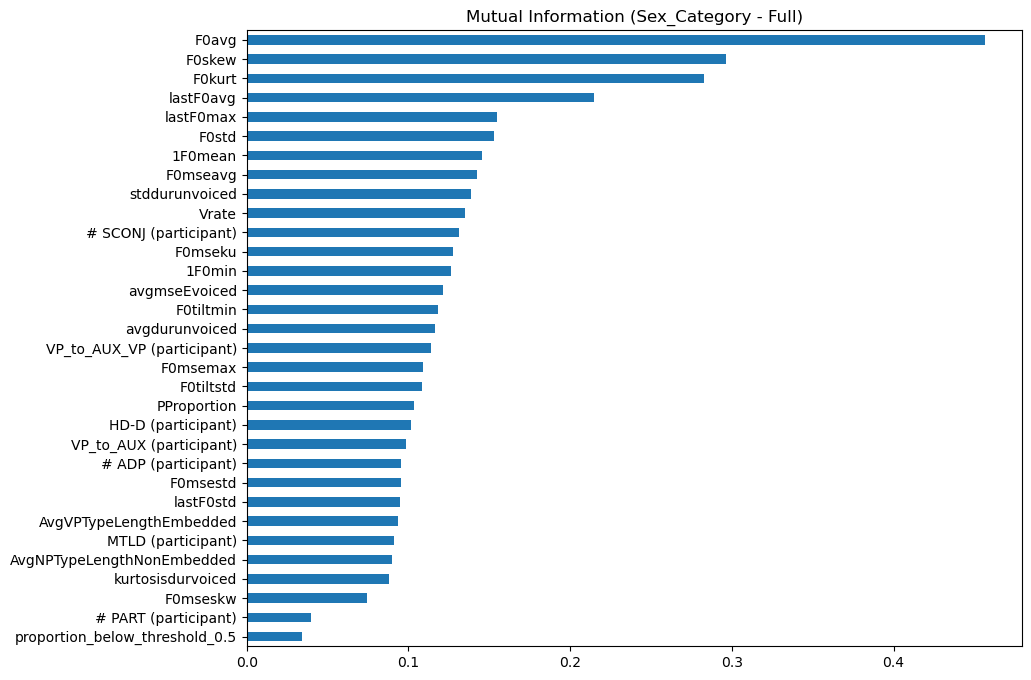

F0avg, F0skew, F0kurt, lastF0avg, lastF0max,
F0std, 1F0mean, F0mseavg, stddurunvoiced, Vrate,
# SCONJ (participant), F0mseku, 1F0min, avgmseEvoiced, F0tiltmin,
avgdurunvoiced, VP_to_AUX_VP (participant), F0msemax, F0tiltstd, PProportion,
HD-D (participant), VP_to_AUX (participant), # ADP (participant), F0msestd, lastF0std,
AvgVPTypeLengthEmbedded, MTLD (participant), AvgNPTypeLengthNonEmbedded, kurtosisdurvoiced, F0mseskw,
# PART (participant), proportion_below_threshold_0.5


In [31]:
MUTUAL_INFO_FULL_COMPUTED_FEATURES = m_info('Sex_Category')

### No Audio

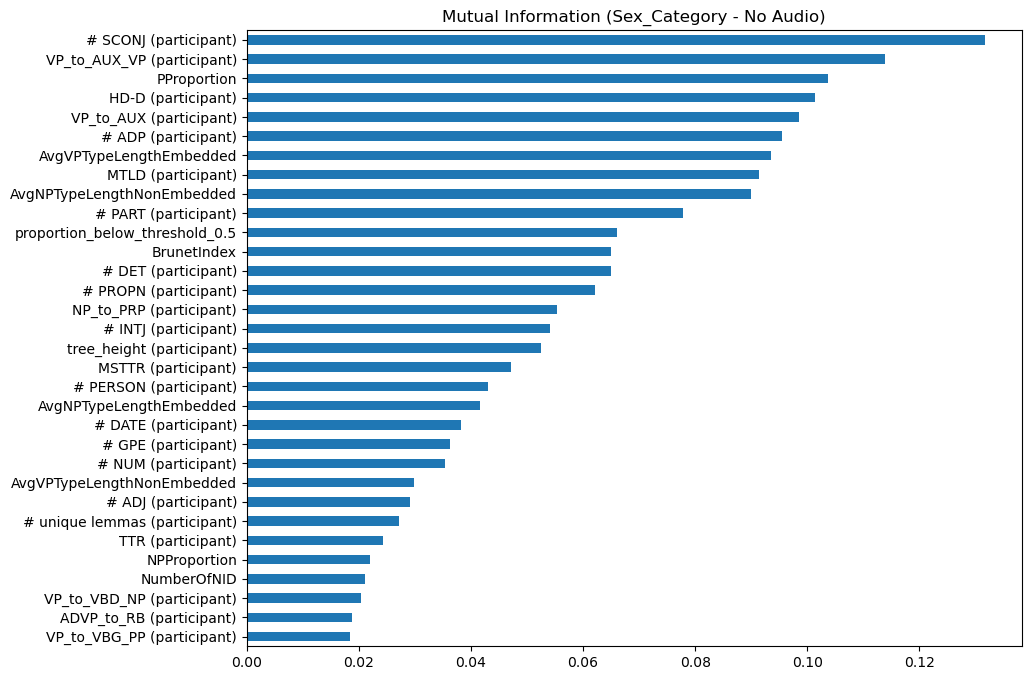

# SCONJ (participant), VP_to_AUX_VP (participant), PProportion, HD-D (participant), VP_to_AUX (participant),
# ADP (participant), AvgVPTypeLengthEmbedded, MTLD (participant), AvgNPTypeLengthNonEmbedded, # PART (participant),
proportion_below_threshold_0.5, BrunetIndex, # DET (participant), # PROPN (participant), NP_to_PRP (participant),
# INTJ (participant), tree_height (participant), MSTTR (participant), # PERSON (participant), AvgNPTypeLengthEmbedded,
# DATE (participant), # GPE (participant), # NUM (participant), AvgVPTypeLengthNonEmbedded, # ADJ (participant),
# unique lemmas (participant), TTR (participant), NPProportion, NumberOfNID, VP_to_VBD_NP (participant),
ADVP_to_RB (participant), VP_to_VBG_PP (participant)


In [32]:
MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('Sex_Category', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [33]:
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s, mean_rocs = [], [], []
    stdev_accs, stdev_f1s, stdev_rocs = [], [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s, rocs = [], [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            rocs.append(roc_auc_score(y_test, y_pred))

        mean_accs.append(round(np.mean(accs),4)), mean_f1s.append(round(np.mean(f1s),4)), mean_rocs.append(round(np.mean(rocs),4))
        stdev_accs.append(round(np.std(accs),4)), stdev_f1s.append(round(np.std(f1s),4)), stdev_rocs.append(round(np.std(rocs),4))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s), (mean_rocs, stdev_rocs)


In [34]:
def plot_metrics(accs, f1s, rocs, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(132)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(133)
    plt.title('Average ROC-AUC Score')
    plt.plot(x_axis, rocs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy:       {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score:       {f1s[0][idx]} +- {f1s[1][idx]}')
        print(f'ROC-AUC Score:  {rocs[0][idx]} +- {rocs[1][idx]}\n')

## Audio

In [35]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME)

X_audio, y_audio = load_raw_data(PATH, 'Sex_Category')

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


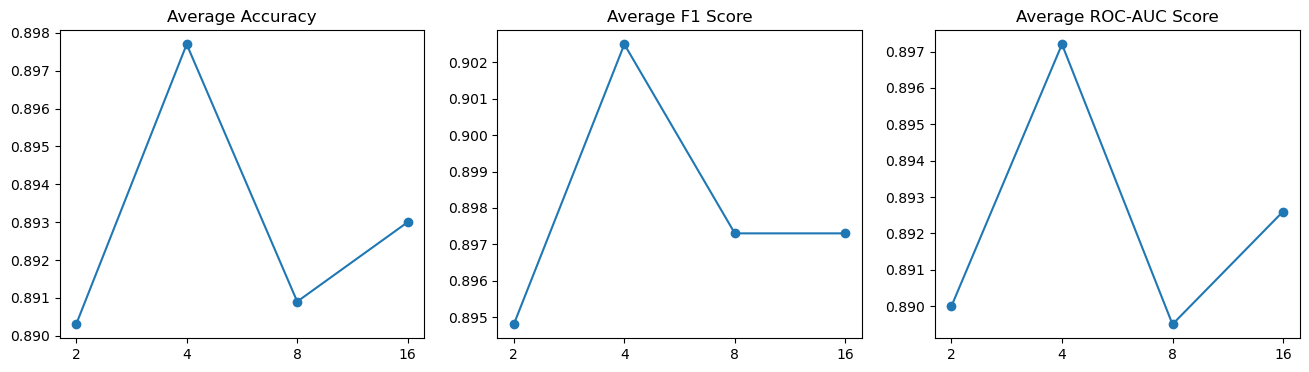

**********   Top 2   **********
Accuracy:       0.8903 +- 0.0594
F1 Score:       0.8948 +- 0.0593
ROC-AUC Score:  0.89 +- 0.0594

**********   Top 4   **********
Accuracy:       0.8977 +- 0.0622
F1 Score:       0.9025 +- 0.0607
ROC-AUC Score:  0.8972 +- 0.0624

**********   Top 8   **********
Accuracy:       0.8909 +- 0.0719
F1 Score:       0.8973 +- 0.0706
ROC-AUC Score:  0.8895 +- 0.0721

**********   Top 16   **********
Accuracy:       0.893 +- 0.0682
F1 Score:       0.8973 +- 0.0681
ROC-AUC Score:  0.8926 +- 0.0682



In [36]:
ml_audio_feats = ML_FULL_COMPUTED_FEATURES[:]
ml_accs, ml_f1s, ml_rocs = check_top_features(X_audio, y_audio, ml_audio_feats)
plot_metrics(ml_accs, ml_f1s, ml_rocs, ml_audio_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


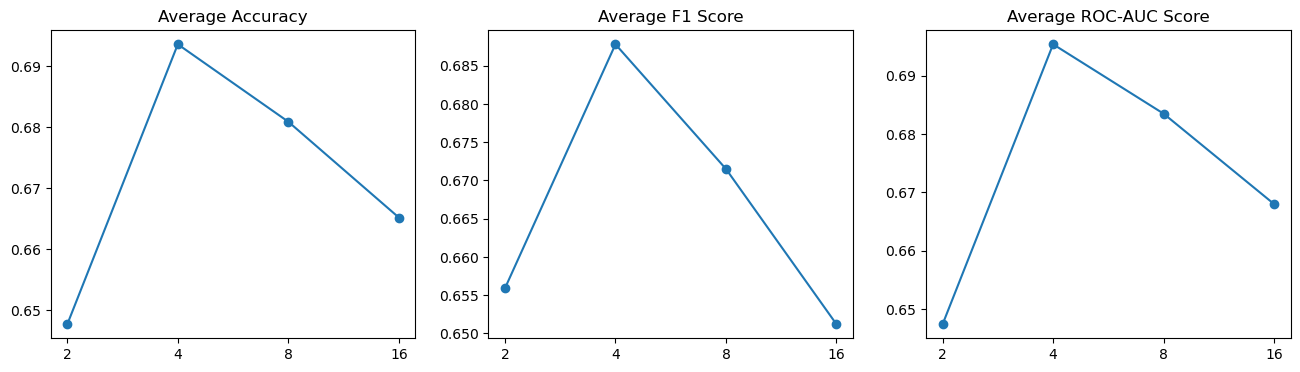

**********   Top 2   **********
Accuracy:       0.6477 +- 0.0917
F1 Score:       0.6559 +- 0.101
ROC-AUC Score:  0.6474 +- 0.0919

**********   Top 4   **********
Accuracy:       0.6936 +- 0.0936
F1 Score:       0.6878 +- 0.1091
ROC-AUC Score:  0.6954 +- 0.093

**********   Top 8   **********
Accuracy:       0.6809 +- 0.0938
F1 Score:       0.6715 +- 0.1081
ROC-AUC Score:  0.6835 +- 0.0938

**********   Top 16   **********
Accuracy:       0.6652 +- 0.0989
F1 Score:       0.6512 +- 0.1215
ROC-AUC Score:  0.668 +- 0.0983



In [37]:
f_classif_feats_audio = F_CLASSIF_FULL_COMPUTED_FEATURES[:]

f_classif_accs_audio, f_classif_f1s_audio, f_classif_rocs_audio = check_top_features(X_audio, y_audio, f_classif_feats_audio)
plot_metrics(f_classif_accs_audio, f_classif_f1s_audio, f_classif_rocs_audio, f_classif_feats_audio)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]


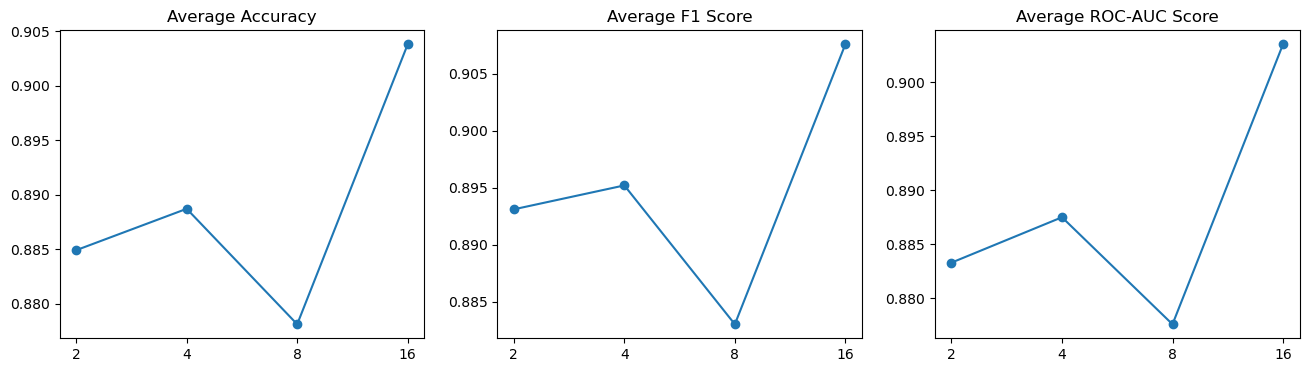

**********   Top 2   **********
Accuracy:       0.8849 +- 0.0689
F1 Score:       0.8931 +- 0.065
ROC-AUC Score:  0.8833 +- 0.0696

**********   Top 4   **********
Accuracy:       0.8887 +- 0.0632
F1 Score:       0.8952 +- 0.0609
ROC-AUC Score:  0.8875 +- 0.0635

**********   Top 8   **********
Accuracy:       0.8781 +- 0.0732
F1 Score:       0.883 +- 0.0731
ROC-AUC Score:  0.8776 +- 0.0732

**********   Top 16   **********
Accuracy:       0.9038 +- 0.0642
F1 Score:       0.9076 +- 0.0641
ROC-AUC Score:  0.9035 +- 0.0641



In [38]:
mutual_info_feats_audio = MUTUAL_INFO_FULL_COMPUTED_FEATURES[:]

mutual_info_accs_audio, mutual_info_f1s_audio, mutual_info_rocs_audio = check_top_features(X_audio, y_audio, mutual_info_feats_audio)
plot_metrics(mutual_info_accs_audio, mutual_info_f1s_audio, mutual_info_rocs_audio, mutual_info_feats_audio)

## No Audio

In [39]:
# Data Loading
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)

X_, y_= load_raw_data(PATH, 'Sex_Category')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:45<00:00,  4.44it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


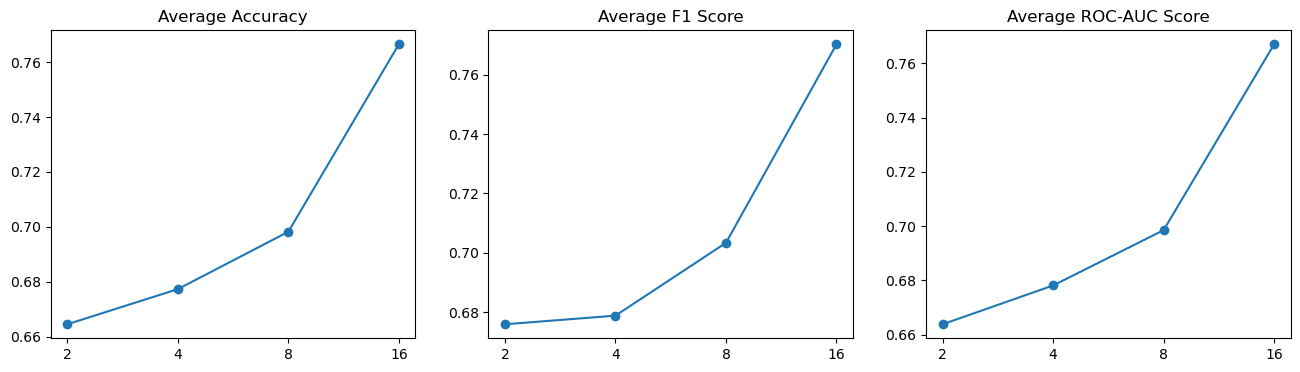

**********   Top 2   **********
Accuracy:       0.6645 +- 0.098
F1 Score:       0.676 +- 0.1037
ROC-AUC Score:  0.6638 +- 0.0983

**********   Top 4   **********
Accuracy:       0.6773 +- 0.093
F1 Score:       0.6789 +- 0.1024
ROC-AUC Score:  0.6781 +- 0.0931

**********   Top 8   **********
Accuracy:       0.6982 +- 0.0941
F1 Score:       0.7034 +- 0.0998
ROC-AUC Score:  0.6985 +- 0.0944

**********   Top 16   **********
Accuracy:       0.7665 +- 0.089
F1 Score:       0.7702 +- 0.0949
ROC-AUC Score:  0.767 +- 0.089



In [40]:
ml_feats = ML_NO_AUDIO_COMPUTED_FEATURES[:]

ml_accs, ml_f1s, ml_rocs = check_top_features(X_, y_, ml_feats)
plot_metrics(ml_accs, ml_f1s, ml_rocs, ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


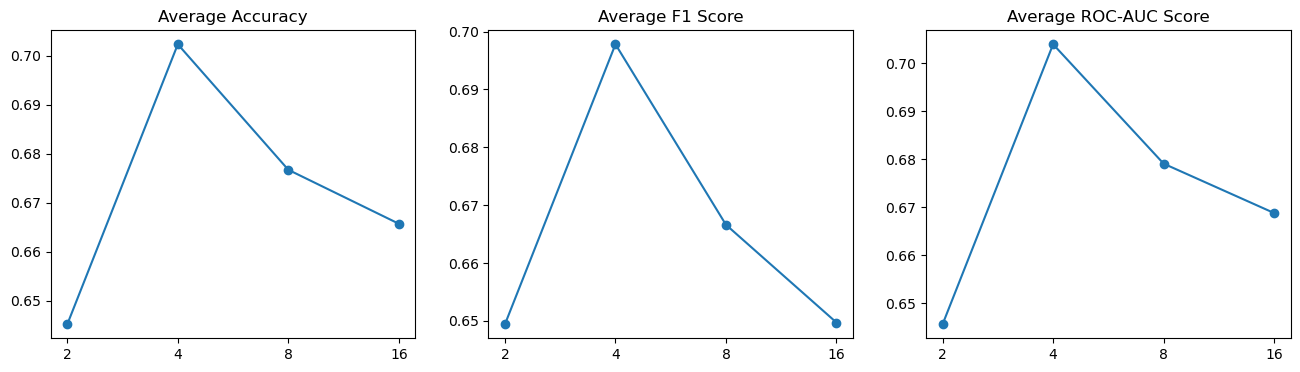

**********   Top 2   **********
Accuracy:       0.6452 +- 0.0914
F1 Score:       0.6494 +- 0.1024
ROC-AUC Score:  0.6456 +- 0.0916

**********   Top 4   **********
Accuracy:       0.7023 +- 0.0952
F1 Score:       0.6978 +- 0.1105
ROC-AUC Score:  0.704 +- 0.0946

**********   Top 8   **********
Accuracy:       0.6767 +- 0.0972
F1 Score:       0.6666 +- 0.1183
ROC-AUC Score:  0.6791 +- 0.0967

**********   Top 16   **********
Accuracy:       0.6657 +- 0.0989
F1 Score:       0.6497 +- 0.123
ROC-AUC Score:  0.6688 +- 0.0985



In [41]:
f_classif_feats = F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

f_classif_accs, f_classif_f1s, f_classif_rocs = check_top_features(X_, y_, f_classif_feats)
plot_metrics(f_classif_accs, f_classif_f1s, f_classif_rocs, f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.67it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


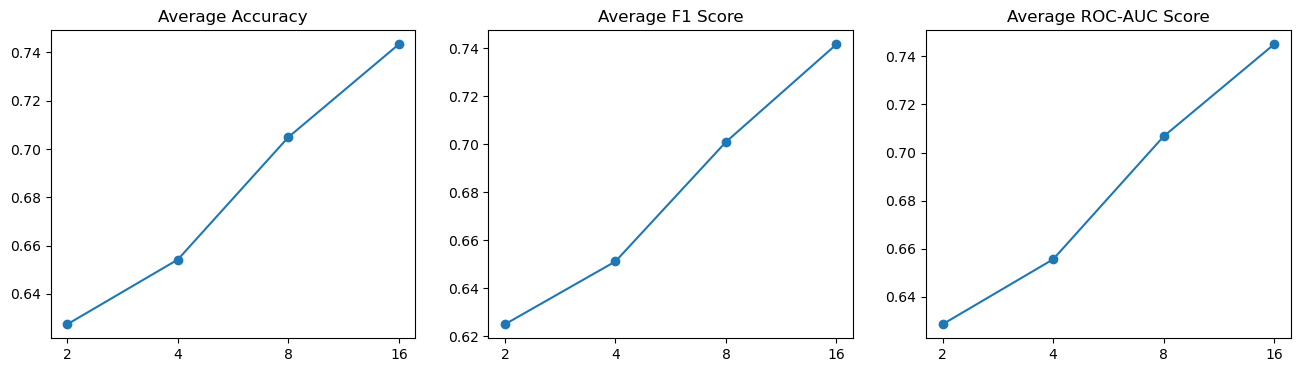

**********   Top 2   **********
Accuracy:       0.6274 +- 0.099
F1 Score:       0.6249 +- 0.1121
ROC-AUC Score:  0.6286 +- 0.0992

**********   Top 4   **********
Accuracy:       0.6542 +- 0.0976
F1 Score:       0.6511 +- 0.1116
ROC-AUC Score:  0.6556 +- 0.0977

**********   Top 8   **********
Accuracy:       0.7049 +- 0.0949
F1 Score:       0.7009 +- 0.1074
ROC-AUC Score:  0.7067 +- 0.0947

**********   Top 16   **********
Accuracy:       0.7434 +- 0.0898
F1 Score:       0.7416 +- 0.0999
ROC-AUC Score:  0.745 +- 0.0896



In [42]:
mutual_info_feats = MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

mutual_info_accs, mutual_info_f1s, mutual_info_rocs = check_top_features(X_, y_, mutual_info_feats)
plot_metrics(mutual_info_accs, mutual_info_f1s, mutual_info_rocs, mutual_info_feats)

#### Mixed Sets

In [43]:
top_features = []
a, b = ml_feats[:16], f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in top_features:
            top_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in top_features:
            top_features.append(b[idx])

top_accs, top_f1s, top_rocs = check_top_features(X_, y_, top_features, [2,4,8,16,18])


Checking top 2 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]



Checking top 16 features


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]



Checking top 18 features


100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s]


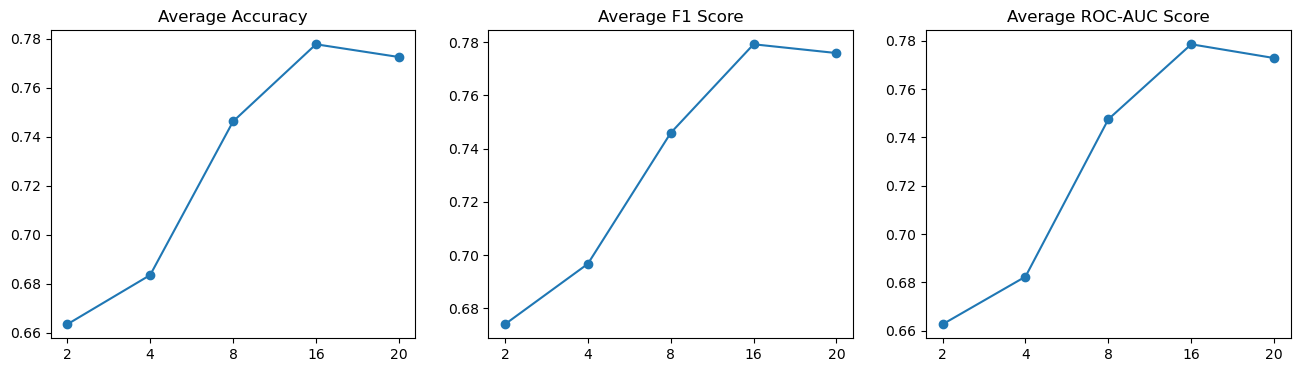

**********   Top 2   **********
Accuracy:       0.6634 +- 0.0932
F1 Score:       0.674 +- 0.1016
ROC-AUC Score:  0.6627 +- 0.0933

**********   Top 4   **********
Accuracy:       0.6835 +- 0.0909
F1 Score:       0.6967 +- 0.0963
ROC-AUC Score:  0.6824 +- 0.0912

**********   Top 8   **********
Accuracy:       0.7462 +- 0.0896
F1 Score:       0.7459 +- 0.0975
ROC-AUC Score:  0.7475 +- 0.0894

**********   Top 16   **********
Accuracy:       0.7777 +- 0.0949
F1 Score:       0.7792 +- 0.1013
ROC-AUC Score:  0.7785 +- 0.0947

**********   Top 20   **********
Accuracy:       0.7725 +- 0.0916
F1 Score:       0.7759 +- 0.0994
ROC-AUC Score:  0.7728 +- 0.0911



In [44]:
plot_metrics(top_accs, top_f1s, top_rocs, top_features, [2,4,8,16,24])

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [72]:
def load_exp(selected_feats, target, typ=int, audio=False):
    # Load the entire csv file
    data = pd.read_csv('data/full_corrected.csv' if audio else 'data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [8]:
import seaborn as sns

MOCA_EXP_FEATS = [
    '# DATE (participant)', 'RatioVerb', '# AUX (participant)', '# unique tokens (participant)',
    'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', '# VERB (participant)', 'proportion_below_threshold_0.5'
 ]
TTAU_EXP_FEATS = [
    'MATTR (participant)', 'VP_to_AUX_VP (participant)', '# TIME (participant)', 'RatioNoun',
    'RatioVerb', 'tree_height (participant)', 'BrunetIndex', 'AvgNPTypeLengthNonEmbedded'
]
AB42_EXP_FEATS = [
    '# TIME (participant)', 'RatioVerb', 'VP_to_AUX_VP (participant)', 'RatioNoun',
    'MATTR (participant)', '# NUM (participant)', '# PROPN (participant)', 'VPTypeRate'
]

TARGETS = ['MOCA_impairment', 'tTau_AB42Positivity', 'AB42_AB40Positivity']

In [61]:
TTAU_EXP_FEATS_AUDIO = [
    'PU', 'UP', 'VP', 'PVU', 'maxdurpause',
    'stddurpause', '1F0std', 'avgdurvoiced'
]

## Variable Correlation

In [128]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target) in enumerate(zip([MOCA_EXP_FEATS, TTAU_EXP_FEATS, AB42_EXP_FEATS], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[target if not special else special[idx]]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[target if not special else special[idx]]))
    return series, annots

In [125]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=3, figsize=(12,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    sns.heatmap(series[2], annot=annots[2], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[2]], fmt = '')
    plt.subplots_adjust(wspace=1.4, top=0.92)
    plt.show()

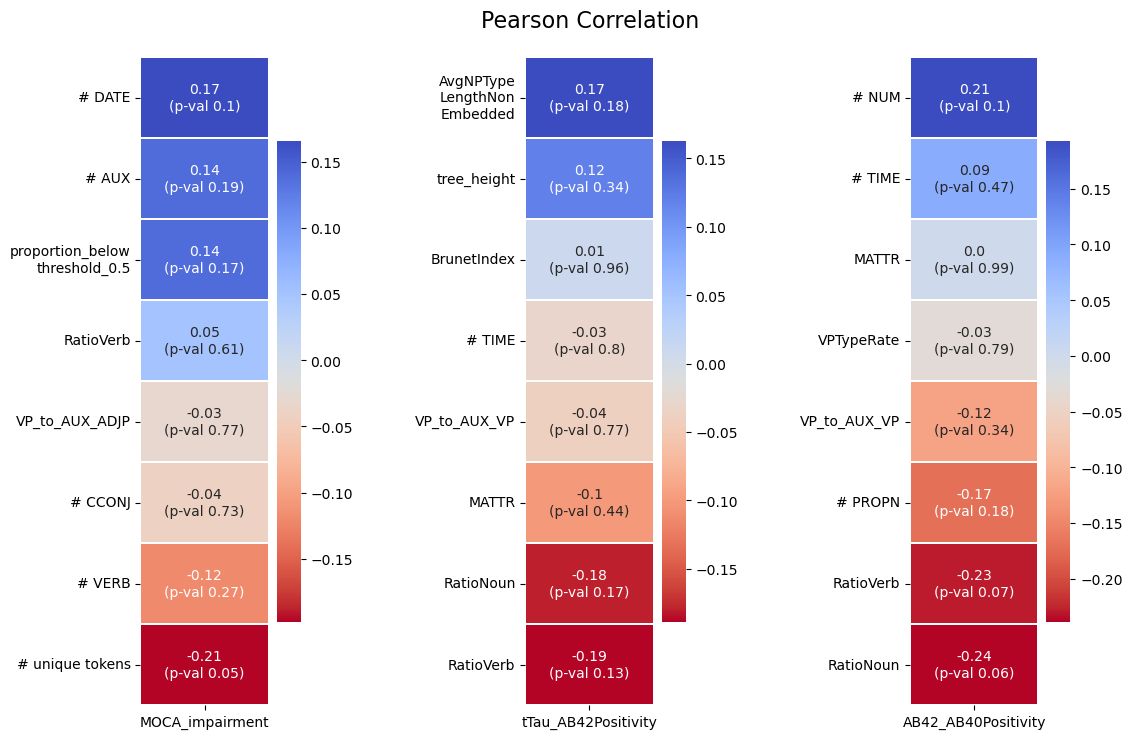

In [129]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

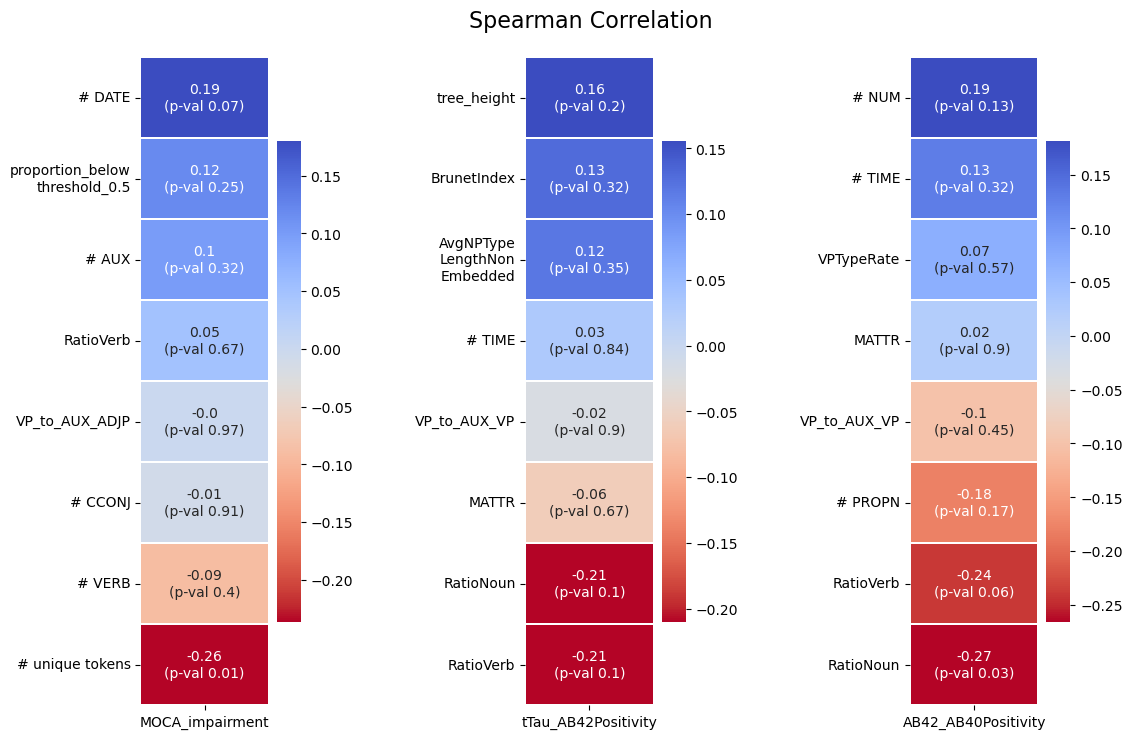

In [130]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

### MOCA
Even taking into consideration both of the correlation functions, only one feature has statistical relevance: `# unique tokens`. Not exactly perfect, but the only meaningful results is also exactly what we do expect: someone healthy should probably generate more unique tokens given more complex/rich language patterns. Thus, the higher `# unique tokens` is, the lower is the probability of observing a dementia patient.

### tTau
Same story as MOCA, the only element that showed some statistical significance (only with Pearson correlation coefficients) is `BrunetIndex`. Once again, this also goes in the direction that we expected because higher BrunetIndex relates to less complex language patterns, so a high BrunetIndex correlates positively with dementia.

### AB42
Here we have 2 features that correlate negatively with Dementia: `RatioVerb` and `RatioNoun`. Also, we see that `MATTR` do not really correlates to anything (at least if we look at the Pearson correlation).

## WRT Clinical Diagnosis

In [72]:
# Filters
def filter_ad(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'MCI'].index)

def filter_mci(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'Prob AD'].index)

In [73]:
# Encodings
def encode_ad_mci(x):
    if x == 'Normal' or x=='Normal-PD':
        return 0
    return 1

def encode_ad(x):
    if x == 'Prob AD':
        return 1
    return 0
        
def encode_mci(x):
    if x == 'MCI':
        return 1
    return 0

### Control vs Prob AD

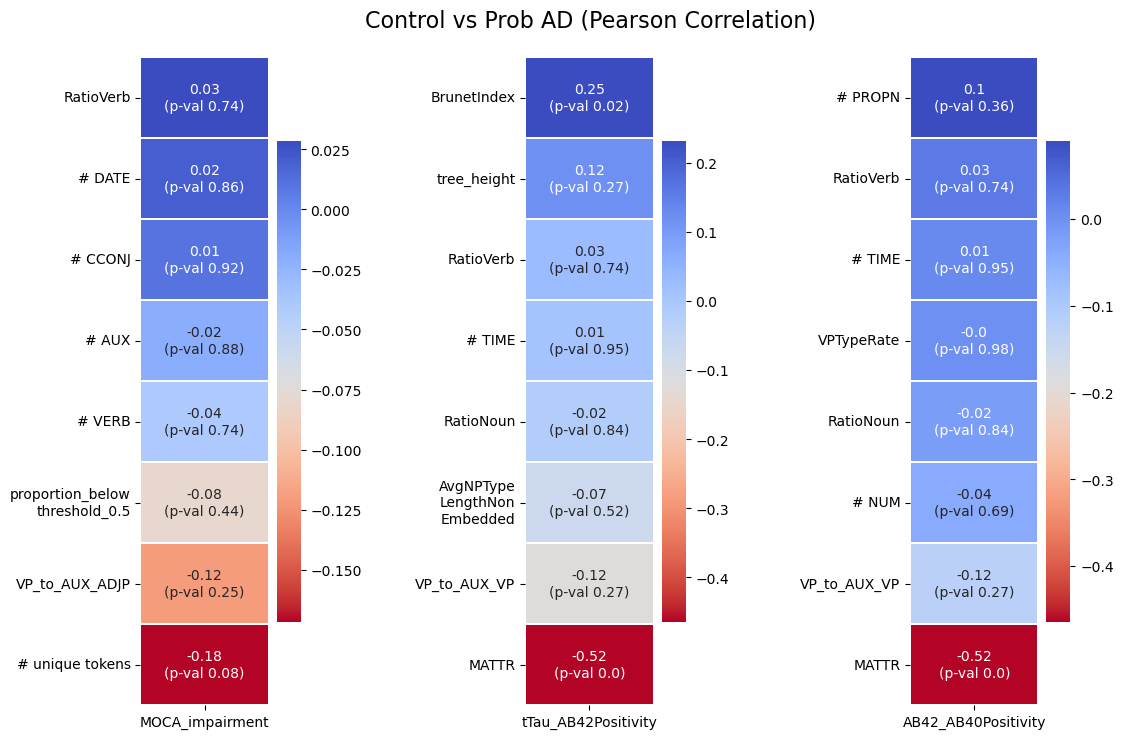

In [131]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Pearson Correlation)")

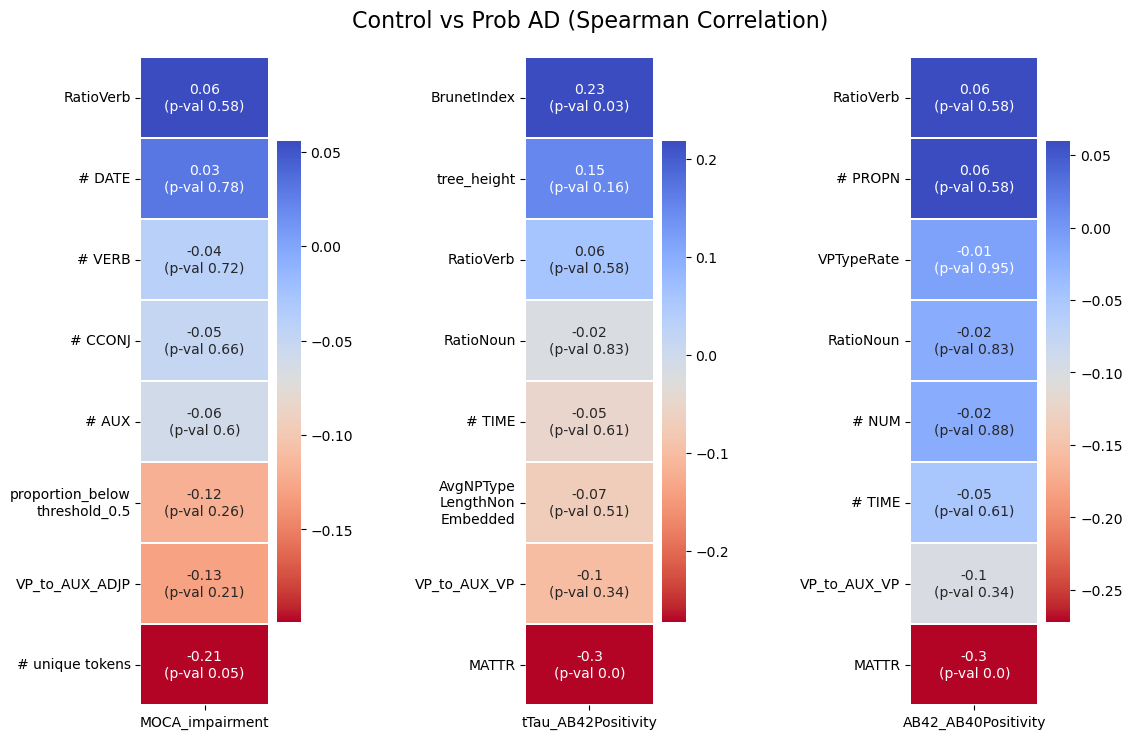

In [132]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Spearman Correlation)")

### MOCA Features
No values with statistical significance.

### tTau Features
Both `MATTR` and `BrunetIndex` show the exact correlation that we may expect (high MATTR = healthy, and high BrunetIndex = dementia).

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI

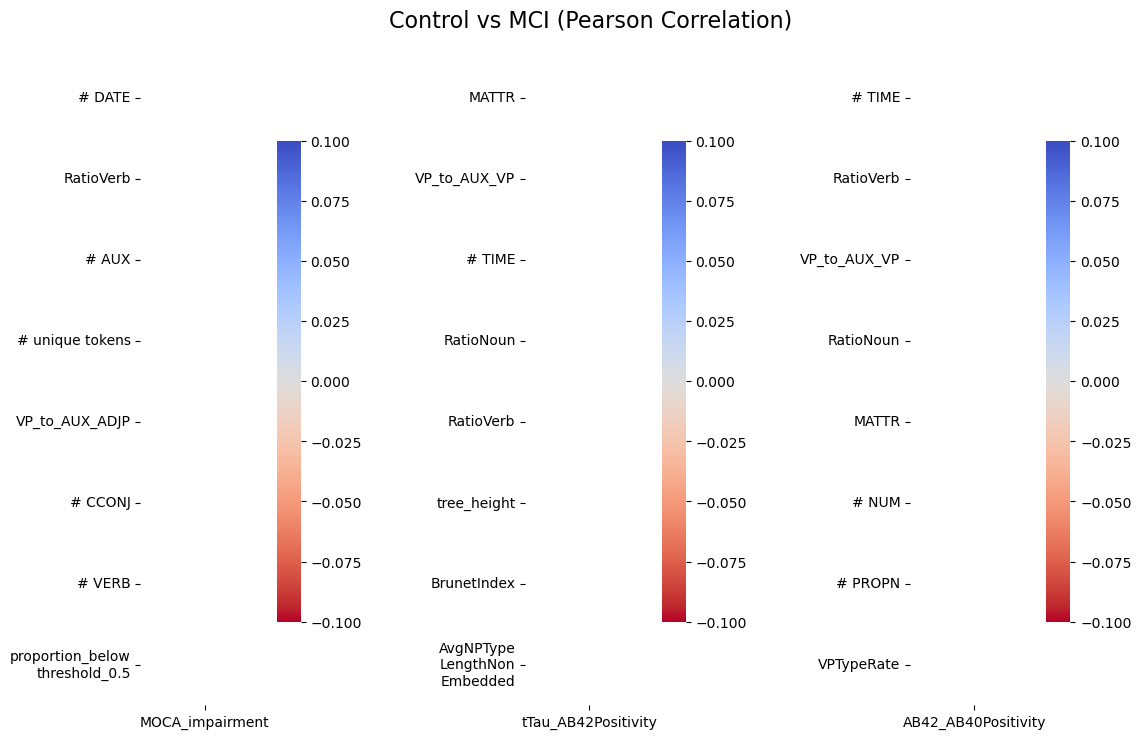

In [133]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_mci, encoding=encode_mci)
plot_correlation(series, annots, "Control vs MCI (Pearson Correlation)")

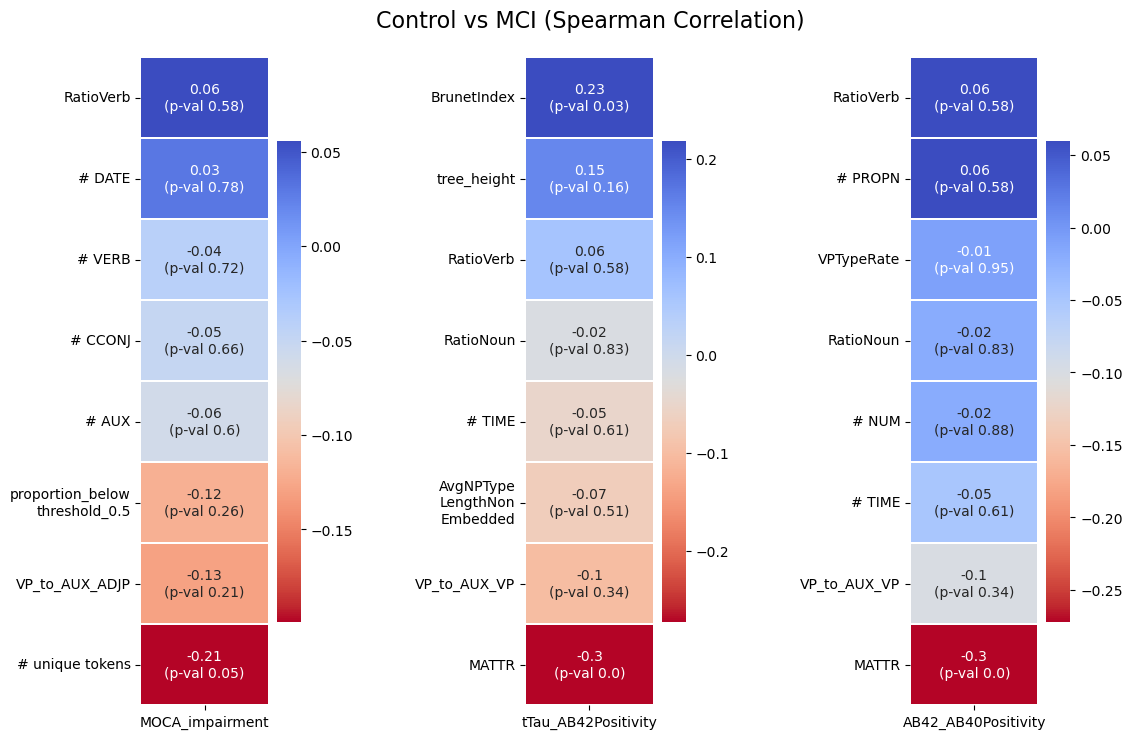

In [134]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI (Spearman Correlation)")

Interestingly, the Pearson correlation refused to produce any values for this experiment. Still unclear if this is a coding problem, or a data problem.

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
Expected correlation for `MATTR`.

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI & Prob AD

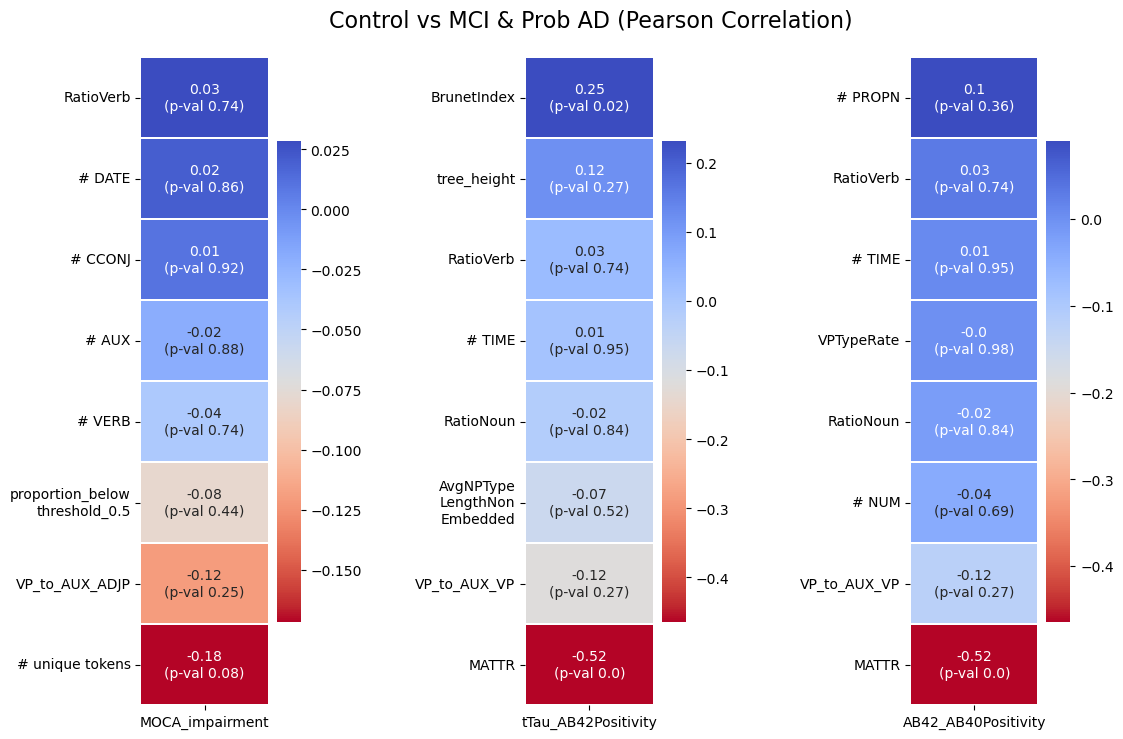

In [135]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Pearson Correlation)")

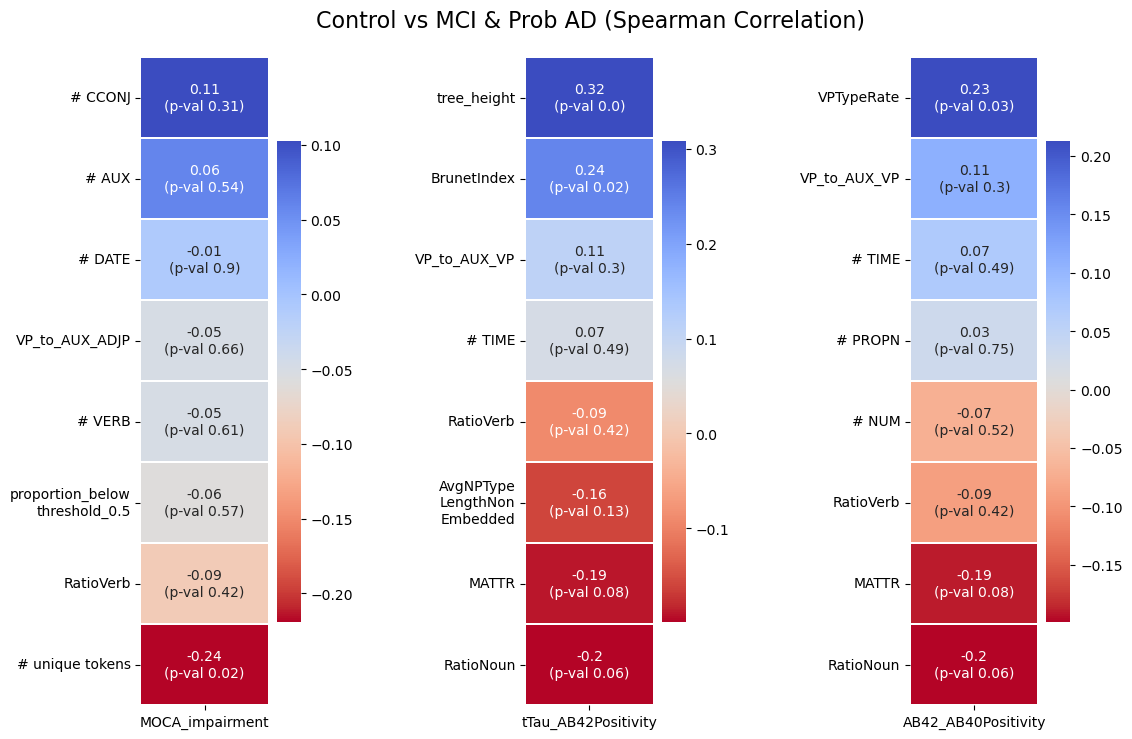

In [136]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, encoding=encode_ad_mci)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Spearman Correlation)")

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
`tree_height` seems to be strongly correlated to dementia parient, and the possible explanation is related to the fact that dementia patient connect a lot of utterances with `AND`, and the tree may have been generated counting all these connected utterances as part of the same sentence, thus generating one enormous tree.

### AB42 Features
No significant values.

## Shap Values

In [62]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [64]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [65]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [66]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [67]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [73]:
def explain(target, features, cv_repetitions, seeds, audio=False):
    df = load_exp(features, target, audio=audio)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [69]:
def plot_shap_vals(X: pd.DataFrame, average_values, label, cv_repetitions):
    cols = []
    for col in list(X.columns):
        if col == 'proportion_below_threshold_0.5':
            col = 'proportion_below\nthreshold_0.5'
        if col == 'AvgNPTypeLengthNonEmbedded':
            col = 'AvgNPTypeLength\nNonEmbedded'
        cols.append(col)
    X.columns = cols
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.xlabel('')
    plt.show()

In [70]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### MOCA_impairment

In [17]:
MOCA_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_moca_exp, moca_class_0, moca_class_1 = explain('MOCA_impairment', MOCA_EXP_FEATS, CV_REPETITIONS, MOCA_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


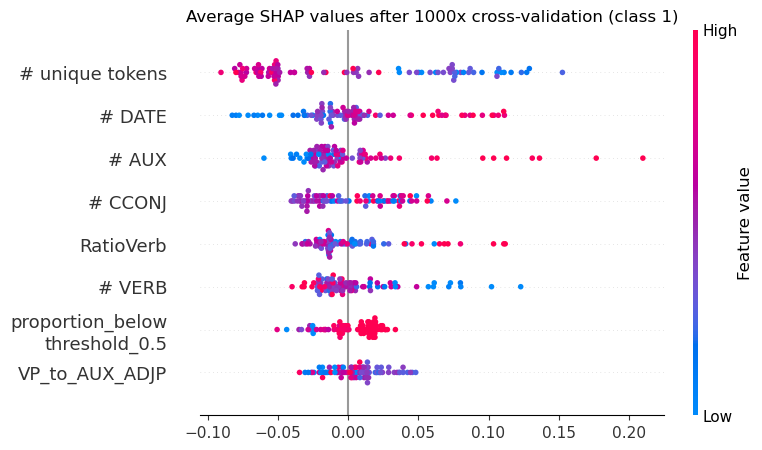

In [18]:
plot_shap_vals(X_moca_exp, moca_class_1[0], 1, CV_REPETITIONS)

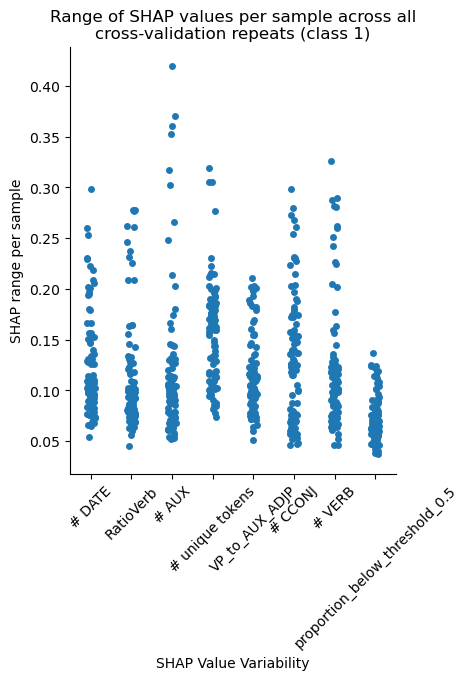

In [101]:
plot_ranges(X_moca_exp, moca_class_1[2], 1)

### tTau_AB42Positivity (no Audio)

In [19]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('tTau_AB42Positivity', TTAU_EXP_FEATS, CV_REPETITIONS, TTAU_SEEDS)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:46<00:00,  1.13it/s]


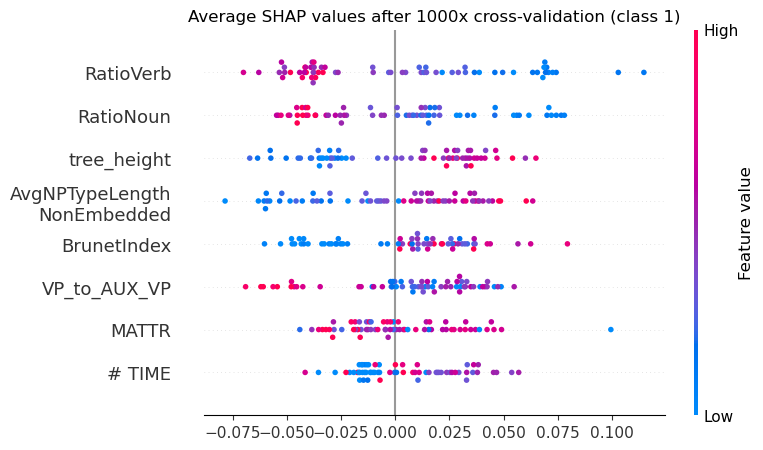

In [20]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

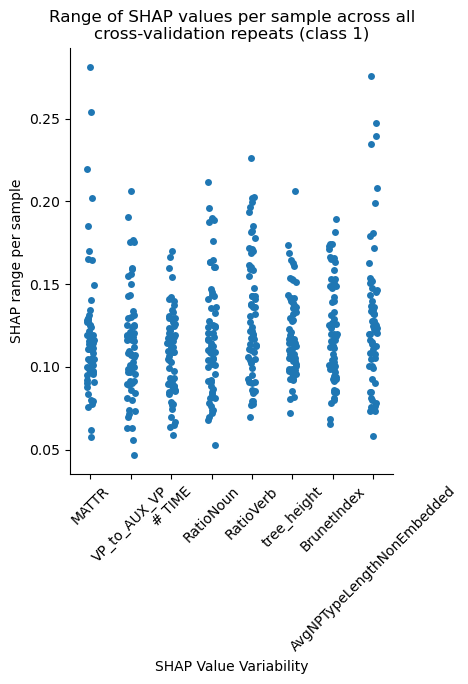

In [103]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### tTau_AB42Positivity (Full)

In [75]:
TTAU_AUDIO_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp_audio, ttau_class_0_audio, ttau_class_1_audio = explain('tTau_AB42Positivity', TTAU_EXP_FEATS_AUDIO, CV_REPETITIONS, TTAU_AUDIO_SEEDS, audio=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [14:54<00:00,  1.12it/s]


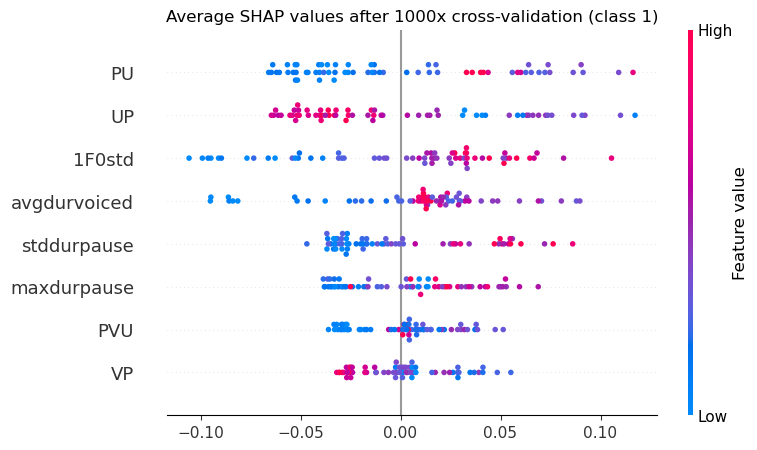

In [76]:
plot_shap_vals(X_ttau_exp_audio, ttau_class_1_audio[0], 1, CV_REPETITIONS)

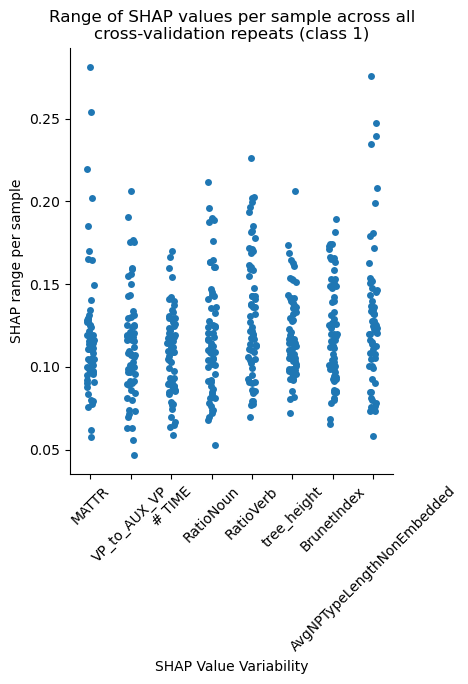

In [ ]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### AB42_AB40Positivity

In [21]:
AB42_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ab42_exp, ab42_class_0, ab42_class_1 = explain('AB42_AB40Positivity', AB42_EXP_FEATS, CV_REPETITIONS, AB42_SEEDS)

100%|██████████| 1000/1000 [14:55<00:00,  1.12it/s]


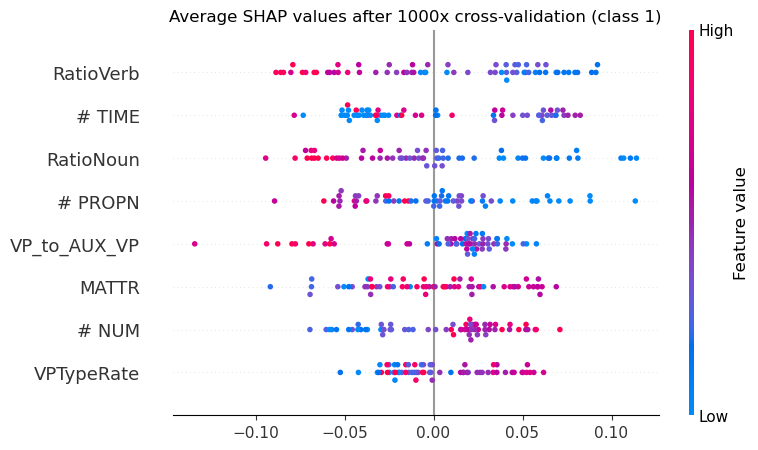

In [22]:
plot_shap_vals(X_ab42_exp, ab42_class_1[0], 1, CV_REPETITIONS)

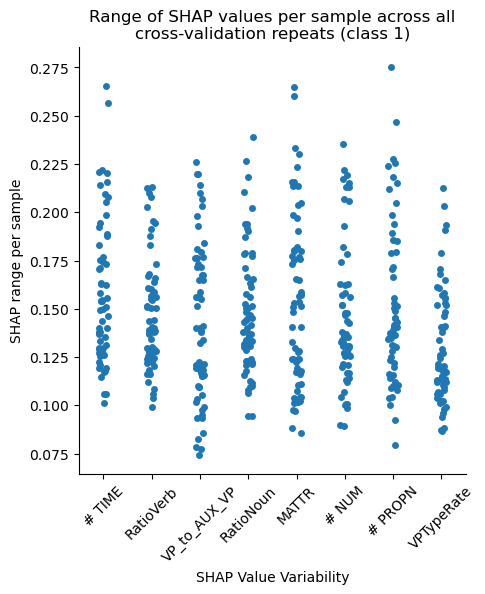

In [106]:
plot_ranges(X_ab42_exp, ab42_class_1[2], 1)